### reference: 

In [1]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss

class AdaBoundW(Optimizer):
    """Implements AdaBound algorithm with Decoupled Weight Decay (arxiv.org/abs/1711.05101)
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBoundW, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBoundW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                if group['weight_decay'] != 0:
                    decayed_weights = torch.mul(p.data, group['weight_decay'])
                    p.data.add_(-step_size)
                    p.data.sub_(decayed_weights)
                else:
                    p.data.add_(-step_size)

        return loss

In [2]:
from functools import partial
from multiprocessing import Pool
import os
from pathlib import Path
import random
import shutil
import time
import xml.etree.ElementTree as ET

from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from scipy.stats import truncnorm
import torch
from torch import nn, optim
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets.folder import default_loader
from torchvision.utils import save_image

In [3]:
start_time = time.time()

batch_size = 32
epochs = 500
seed = 1029

TRAIN_DIR = Path('../input/all-dogs/')
ANNOTATION_DIR = Path('../input/annotation/Annotation/')
DOG_DIR = Path('../dogs/dogs/')
OUT_DIR = Path('../output_images/')
DOG_DIR.mkdir(parents=True, exist_ok=True)
OUT_DIR.mkdir(exist_ok=True)

device = torch.device('cuda')

lr = 1e-2
beta1 = 0.5
nz = 256

real_label = 0.9
fake_label = 0.0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
class Generator(nn.Module):
    
    def __init__(self, nz=128, channels=3):
        super(Generator, self).__init__()
        self.nz = nz
        self.channels = channels
        
        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block

        self.model = nn.Sequential(
            *convlayer(self.nz, 1024, 4, 1, 0),
            *convlayer(1024, 512, 4, 2, 1),
            *convlayer(512, 256, 4, 2, 1),
            *convlayer(256, 128, 4, 2, 1),
            *convlayer(128, 64, 4, 2, 1),
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.nz, 1, 1)
        img = self.model(z)
        return img


class Discriminator(nn.Module):
    
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.channels = channels

        def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block

        self.model = nn.Sequential(
            *convlayer(self.channels, 32, 4, 2, 1),
            *convlayer(32, 64, 4, 2, 1),
            *convlayer(64, 128, 4, 2, 1, bn=True),
            *convlayer(128, 256, 4, 2, 1, bn=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        )

    def forward(self, imgs):
        out = self.model(imgs)
        return out.view(-1, 1)

In [5]:
class DogsDataset(Dataset):
    
    def __init__(self, root, annotation_root, transform=None,
                 target_transform=None, loader=default_loader, n_process=4):
        self.root = Path(root)
        self.annotation_root = Path(annotation_root)
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
        self.imgs = self.cut_out_dogs(n_process)

    def _get_annotation_path(self, img_path):
        dog = Path(img_path).stem
        breed = dog.split('_')[0]
        breed_dir = next(self.annotation_root.glob(f'{breed}-*'))
        return breed_dir / dog
    
    @staticmethod
    def _get_dog_box(annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            yield (xmin, ymin, xmax, ymax)
            
    def crop_dog(self, path):
        imgs = []
        annotation_path = self._get_annotation_path(path)
        for bndbox in self._get_dog_box(annotation_path):
            img = self.loader(path)
            img_ = img.crop(bndbox)
            if np.sum(img_) != 0:
                img = img_
            imgs.append(img)
        return imgs
                
    def cut_out_dogs(self, n_process):
        with Pool(n_process) as p:
            imgs = p.map(self.crop_dog, self.root.iterdir())
        return imgs
    
    def __getitem__(self, index):
        samples = random.choice(self.imgs[index])
        if self.transform is not None:
            samples = self.transform(samples)
        return samples
    
    def __len__(self):
        return len(self.imgs)

In [6]:
class ParamScheduler(object):
    
    def __init__(self, optimizer, scale_fn, step_size):
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        
        self.optimizer = optimizer
        self.scale_fn = scale_fn
        self.step_size = step_size
        self.last_batch_iteration = 0
        
    def batch_step(self):
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.scale_fn(self.last_batch_iteration / self.step_size)
        
        self.last_batch_iteration += 1


def combine_scale_functions(scale_fns, phases=None):
    if phases is None:
        phases = [1. / len(scale_fns)] * len(scale_fns)
    phases = [phase / sum(phases) for phase in phases]
    phases = torch.tensor([0] + phases)
    phases = torch.cumsum(phases, 0)
    
    def _inner(x):
        idx = (x >= phases).nonzero().max()
        actual_x = (x - phases[idx]) / (phases[idx + 1] - phases[idx])
        return scale_fns[idx](actual_x)
        
    return _inner


def scale_cos(start, end, x):
    return start + (1 + np.cos(np.pi * (1 - x))) * (end - start) / 2

In [7]:
random_transforms = [transforms.RandomRotation(degrees=5)]
transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.3),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = DogsDataset(TRAIN_DIR / 'all-dogs/', ANNOTATION_DIR, transform=transform)
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)

imgs = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

net_g = Generator(nz).to(device)
net_d = Discriminator().to(device)

criterion = nn.BCELoss()
scale_fn = combine_scale_functions(
    [partial(scale_cos, 1e-5, 5e-4), partial(scale_cos, 5e-4, 1e-4)], [0.2, 0.8])

optimizer_g = AdaBound(net_g.parameters(), lr=lr, final_lr=0.5,betas=(beta1, 0.999))
optimizer_d = AdaBound(net_d.parameters(), lr=0.0005, final_lr=0.1,betas=(beta1, 0.999))

torch.backends.cudnn.benchmark = True

# optimizer_g = optim.Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizer_d = optim.Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))

scheduler_g = ParamScheduler(optimizer_g, scale_fn, epochs * len(train_loader))
scheduler_d = ParamScheduler(optimizer_d, scale_fn, epochs * len(train_loader))

In [8]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values

[1/500] Loss_d: 0.3700 Loss_g: 2.5419


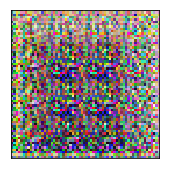

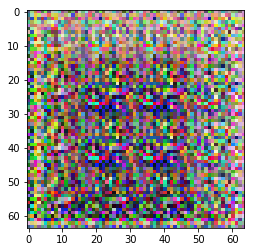

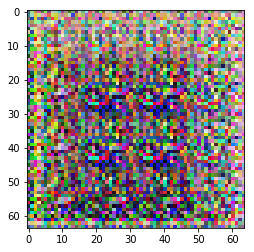

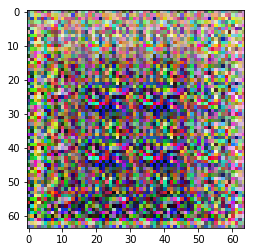

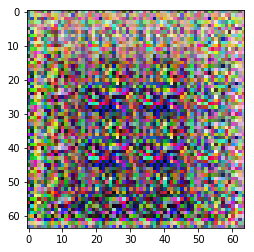

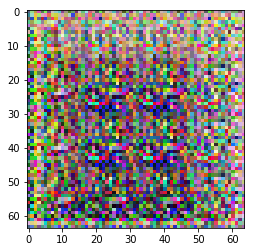

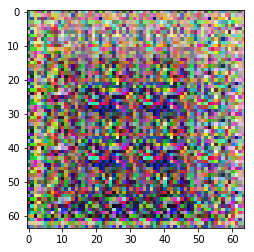

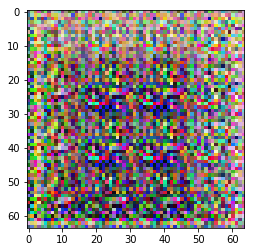

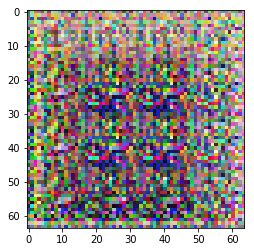

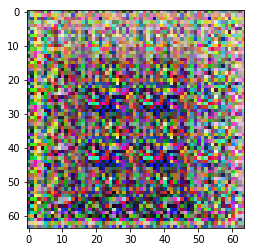

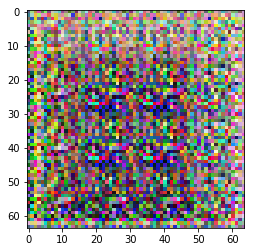

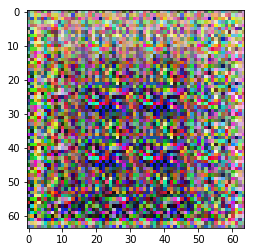

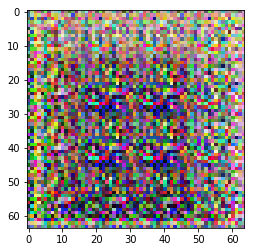

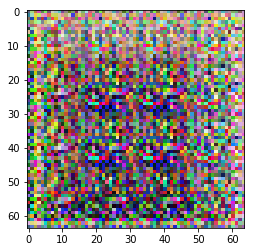

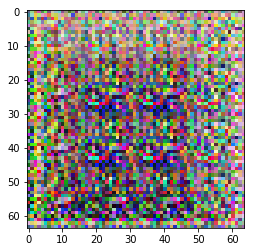

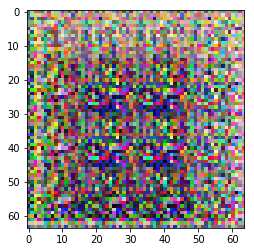

[2/500] Loss_d: 0.0262 Loss_g: 2.8672
[3/500] Loss_d: 0.0960 Loss_g: 3.3203
[4/500] Loss_d: 0.0949 Loss_g: 3.3700
[5/500] Loss_d: 0.5149 Loss_g: 3.2804
[6/500] Loss_d: 0.1369 Loss_g: 3.7755
[7/500] Loss_d: 0.3739 Loss_g: 2.5612
[8/500] Loss_d: 0.0387 Loss_g: 3.9508
[9/500] Loss_d: 1.8344 Loss_g: 2.8908
[10/500] Loss_d: 2.0795 Loss_g: 0.2946
[11/500] Loss_d: 0.0342 Loss_g: 3.9649
[12/500] Loss_d: 0.1256 Loss_g: 5.1058
[13/500] Loss_d: 0.3064 Loss_g: 0.8891
[14/500] Loss_d: 0.8637 Loss_g: 8.7829
[15/500] Loss_d: 0.0852 Loss_g: 4.7548
[16/500] Loss_d: 0.1248 Loss_g: 9.1228
[17/500] Loss_d: 0.0425 Loss_g: 4.8546
[18/500] Loss_d: 0.9257 Loss_g: 26.4038
[19/500] Loss_d: 0.2896 Loss_g: 8.3072
[20/500] Loss_d: 0.6301 Loss_g: 8.1150
[21/500] Loss_d: 1.2841 Loss_g: 13.9241
[22/500] Loss_d: 0.8771 Loss_g: 8.2232
[23/500] Loss_d: 0.9288 Loss_g: 15.9952
[24/500] Loss_d: 0.9810 Loss_g: 5.2438
[25/500] Loss_d: 0.6603 Loss_g: 15.0781
[26/500] Loss_d: 0.0798 Loss_g: 6.1668
[27/500] Loss_d: 0.0512 Loss_

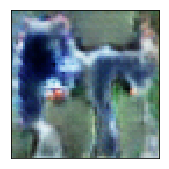

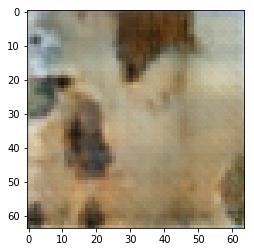

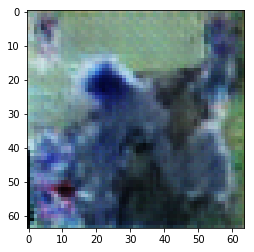

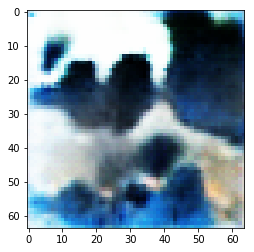

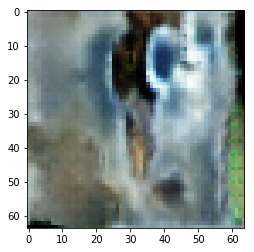

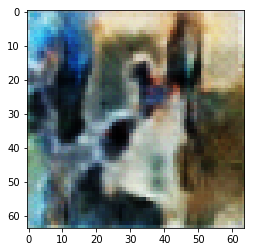

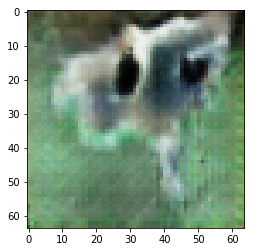

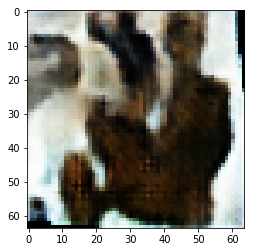

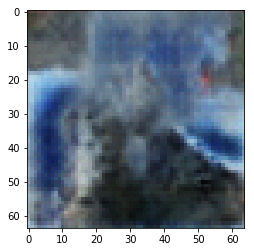

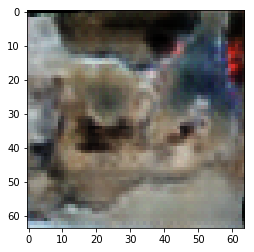

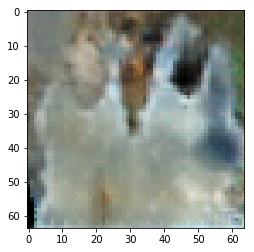

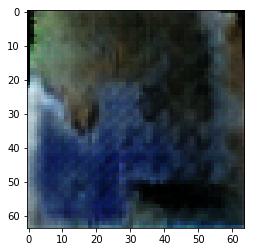

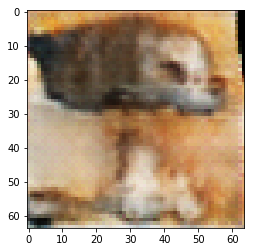

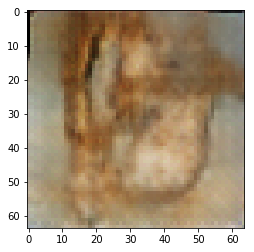

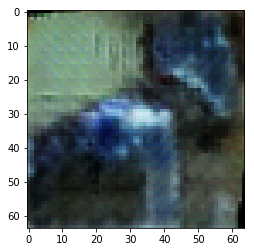

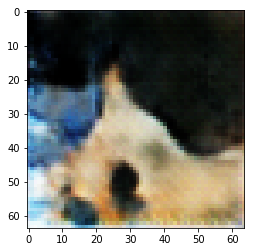

[32/500] Loss_d: 0.1884 Loss_g: 7.2652
[33/500] Loss_d: 0.0901 Loss_g: 7.5813
[34/500] Loss_d: 0.3562 Loss_g: 11.9838
[35/500] Loss_d: 1.9319 Loss_g: 22.5746
[36/500] Loss_d: 0.9395 Loss_g: 31.6073
[37/500] Loss_d: 1.2627 Loss_g: 28.0539
[38/500] Loss_d: 0.1624 Loss_g: 0.5303
[39/500] Loss_d: 0.2971 Loss_g: 8.1972
[40/500] Loss_d: 0.5418 Loss_g: 17.8268
[41/500] Loss_d: 0.4797 Loss_g: 23.4785
[42/500] Loss_d: 2.3520 Loss_g: 29.8467
[43/500] Loss_d: 0.4254 Loss_g: 0.7394
[44/500] Loss_d: 0.4508 Loss_g: 18.3921
[45/500] Loss_d: 1.8944 Loss_g: 29.8981
[46/500] Loss_d: 1.0179 Loss_g: 22.2096
[47/500] Loss_d: 1.7613 Loss_g: 45.5767
[48/500] Loss_d: 0.3789 Loss_g: 13.7151
[49/500] Loss_d: 0.0827 Loss_g: 1.3533
[50/500] Loss_d: 0.4537 Loss_g: 13.0798
[51/500] Loss_d: 0.5991 Loss_g: 18.4169
[52/500] Loss_d: 2.2031 Loss_g: 15.5676
[53/500] Loss_d: 0.2289 Loss_g: 10.8485
[54/500] Loss_d: 0.0654 Loss_g: 3.7132
[55/500] Loss_d: 0.7558 Loss_g: 13.5392
[56/500] Loss_d: 0.0331 Loss_g: 4.5443
[57/500]

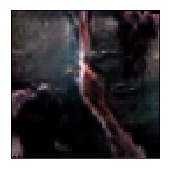

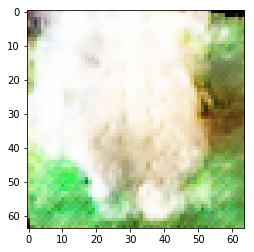

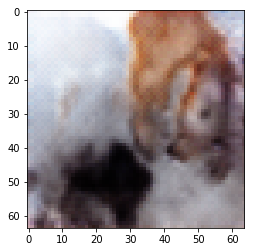

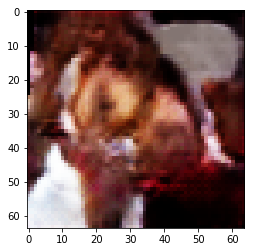

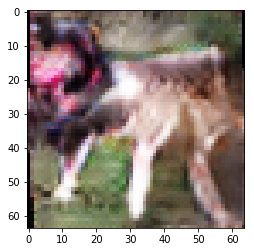

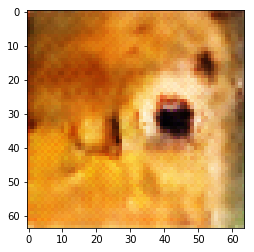

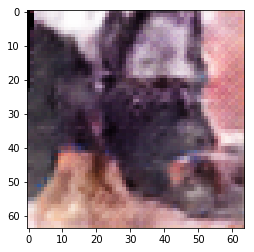

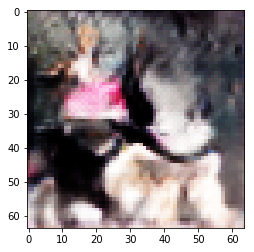

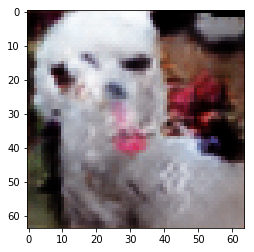

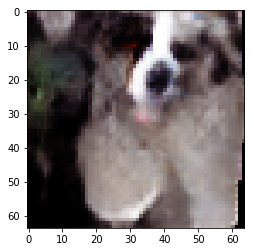

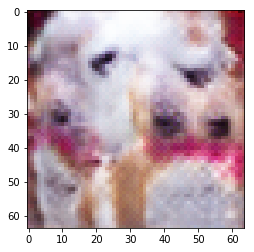

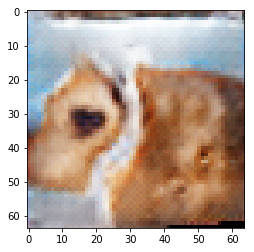

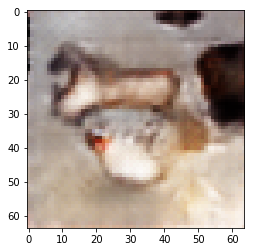

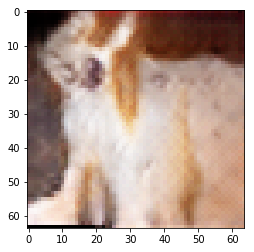

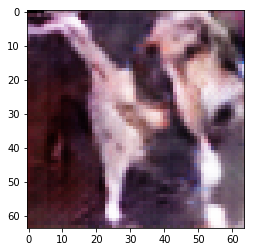

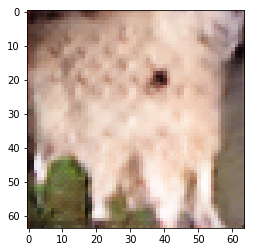

[62/500] Loss_d: 0.3925 Loss_g: 5.5904
[63/500] Loss_d: 0.3280 Loss_g: 4.0672
[64/500] Loss_d: 1.0525 Loss_g: 4.3259
[65/500] Loss_d: 0.2017 Loss_g: 2.9279
[66/500] Loss_d: 0.0325 Loss_g: 3.5383
[67/500] Loss_d: 0.0589 Loss_g: 3.9796
[68/500] Loss_d: 0.5988 Loss_g: 2.5449
[69/500] Loss_d: 0.2408 Loss_g: 3.0065
[70/500] Loss_d: 0.0734 Loss_g: 2.6862
[71/500] Loss_d: 0.0650 Loss_g: 2.9681
[72/500] Loss_d: 0.0087 Loss_g: 3.4223
[73/500] Loss_d: 0.4287 Loss_g: 4.4144
[74/500] Loss_d: 0.0496 Loss_g: 3.3748
[75/500] Loss_d: 0.8660 Loss_g: 4.4236
[76/500] Loss_d: 0.4379 Loss_g: 3.0883
[77/500] Loss_d: 0.1206 Loss_g: 3.3099
[78/500] Loss_d: 0.0650 Loss_g: 3.4590
[79/500] Loss_d: 0.0148 Loss_g: 3.0466
[80/500] Loss_d: 0.0026 Loss_g: 3.6170
[81/500] Loss_d: 0.0081 Loss_g: 3.4876
[82/500] Loss_d: 0.1003 Loss_g: 2.9040
[83/500] Loss_d: 0.0111 Loss_g: 2.9336
[84/500] Loss_d: 0.0110 Loss_g: 2.6847
[85/500] Loss_d: 0.2109 Loss_g: 3.3006
[86/500] Loss_d: 0.0138 Loss_g: 2.8473
[87/500] Loss_d: 0.0277 L

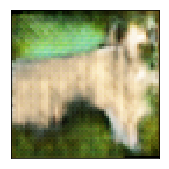

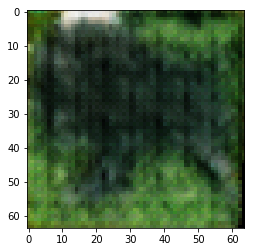

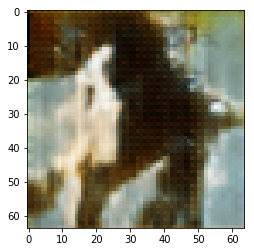

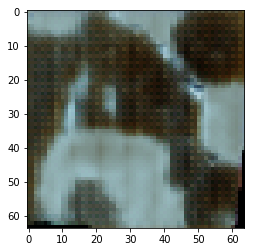

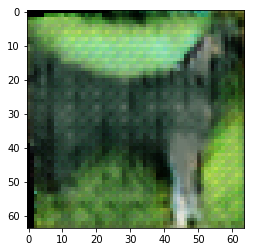

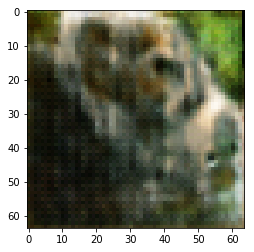

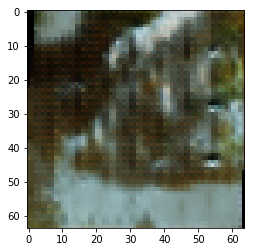

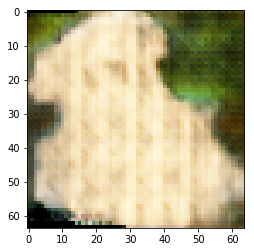

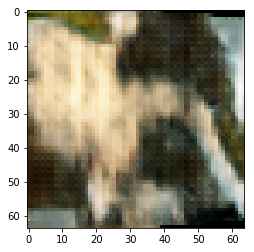

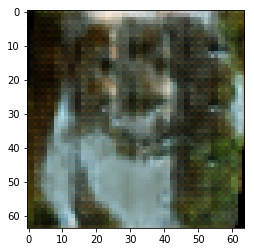

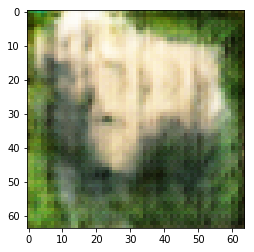

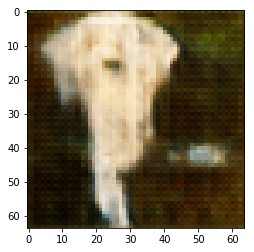

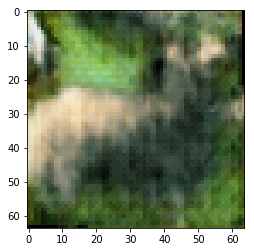

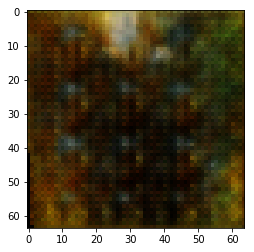

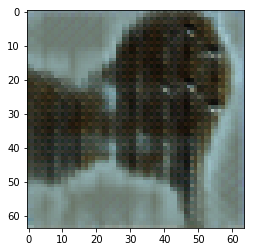

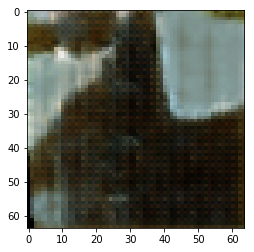

[92/500] Loss_d: 0.1078 Loss_g: 3.4695
[93/500] Loss_d: 0.1302 Loss_g: 3.0212
[94/500] Loss_d: 0.5075 Loss_g: 1.9123
[95/500] Loss_d: 0.0055 Loss_g: 2.8738
[96/500] Loss_d: 0.0659 Loss_g: 2.9286
[97/500] Loss_d: 0.1252 Loss_g: 2.8805
[98/500] Loss_d: 0.0858 Loss_g: 3.1117
[99/500] Loss_d: 0.0479 Loss_g: 3.0216
[100/500] Loss_d: 0.2117 Loss_g: 2.7858
[101/500] Loss_d: 0.1704 Loss_g: 2.9727
[102/500] Loss_d: 0.2663 Loss_g: 2.4818
[103/500] Loss_d: 0.0372 Loss_g: 3.5065
[104/500] Loss_d: 0.0542 Loss_g: 2.9368
[105/500] Loss_d: 0.0023 Loss_g: 3.2723
[106/500] Loss_d: 0.0338 Loss_g: 3.6676
[107/500] Loss_d: 0.0025 Loss_g: 2.9702
[108/500] Loss_d: 0.2508 Loss_g: 2.9458
[109/500] Loss_d: 0.0056 Loss_g: 3.2588
[110/500] Loss_d: 0.0697 Loss_g: 2.7810
[111/500] Loss_d: 0.0085 Loss_g: 3.2047
[112/500] Loss_d: 0.0192 Loss_g: 2.6217
[113/500] Loss_d: 0.3869 Loss_g: 2.6331
[114/500] Loss_d: 0.2204 Loss_g: 2.0084
[115/500] Loss_d: 0.2249 Loss_g: 3.0370
[116/500] Loss_d: 0.0176 Loss_g: 3.3030
[117/500

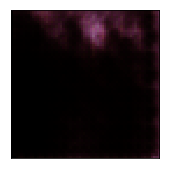

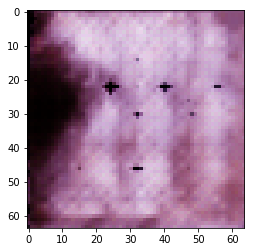

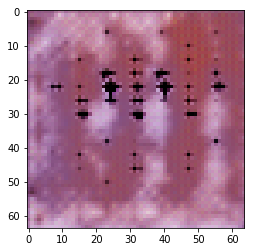

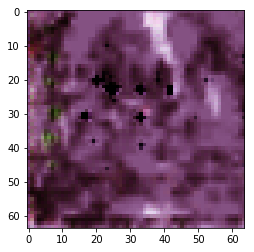

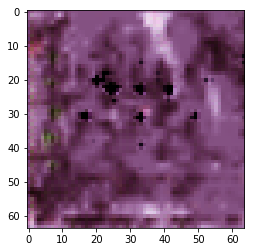

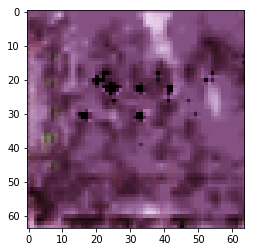

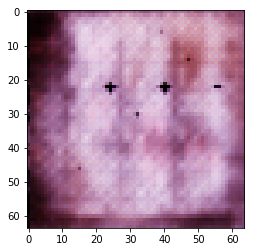

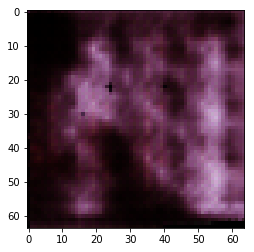

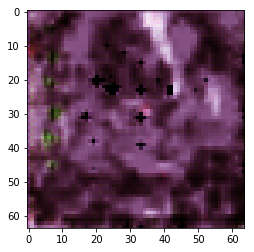

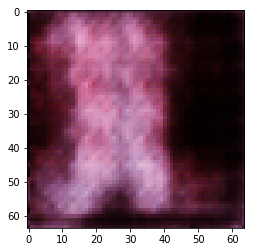

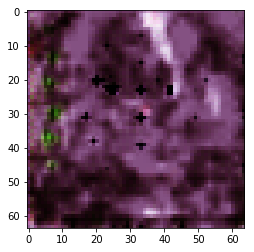

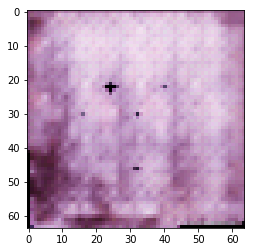

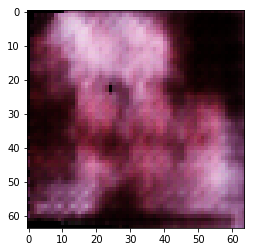

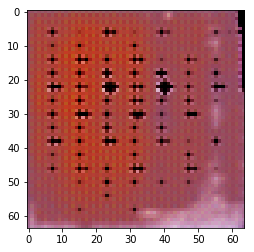

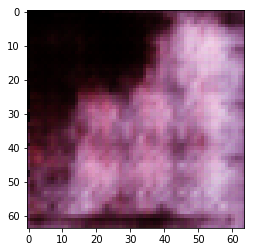

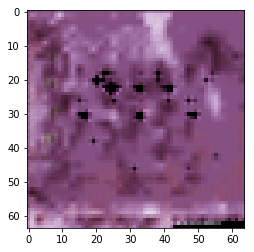

[122/500] Loss_d: 0.0020 Loss_g: 3.3156
[123/500] Loss_d: 0.0224 Loss_g: 3.4382
[124/500] Loss_d: 0.4942 Loss_g: 3.3060
[125/500] Loss_d: 0.0972 Loss_g: 3.1747
[126/500] Loss_d: 0.0145 Loss_g: 3.4052
[127/500] Loss_d: 0.2314 Loss_g: 2.5433
[128/500] Loss_d: 0.3079 Loss_g: 2.3326
[129/500] Loss_d: 0.2466 Loss_g: 2.2168
[130/500] Loss_d: 0.0801 Loss_g: 2.7806
[131/500] Loss_d: 0.2603 Loss_g: 2.1013
[132/500] Loss_d: 0.1033 Loss_g: 2.8283
[133/500] Loss_d: 0.1108 Loss_g: 2.6685
[134/500] Loss_d: 0.0599 Loss_g: 2.7650
[135/500] Loss_d: 0.0053 Loss_g: 3.1898
[136/500] Loss_d: 0.0190 Loss_g: 3.7065
[137/500] Loss_d: 0.0911 Loss_g: 3.7654
[138/500] Loss_d: 0.0025 Loss_g: 3.2055
[139/500] Loss_d: 0.6568 Loss_g: 2.1274
[140/500] Loss_d: 0.1044 Loss_g: 2.7825
[141/500] Loss_d: 0.2103 Loss_g: 3.4861
[142/500] Loss_d: 0.3003 Loss_g: 2.4255
[143/500] Loss_d: 0.0639 Loss_g: 2.9534
[144/500] Loss_d: 0.1109 Loss_g: 2.5104
[145/500] Loss_d: 0.0713 Loss_g: 2.4712
[146/500] Loss_d: 1.0768 Loss_g: 1.3268


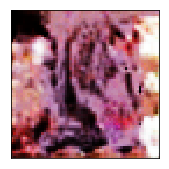

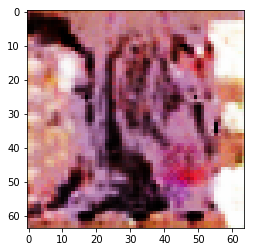

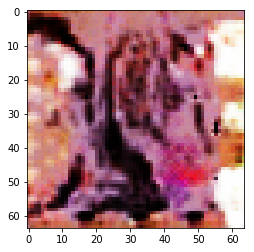

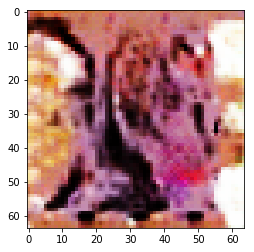

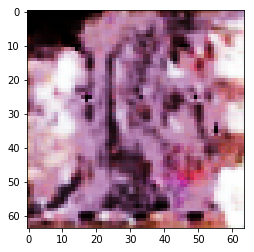

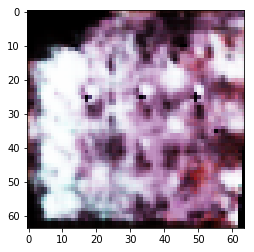

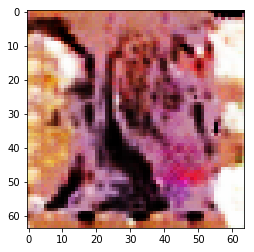

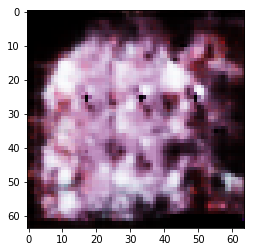

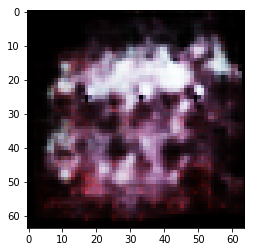

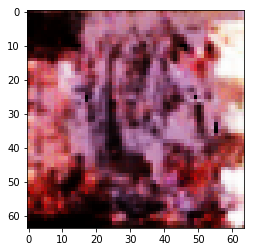

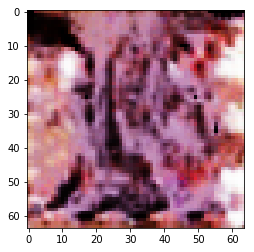

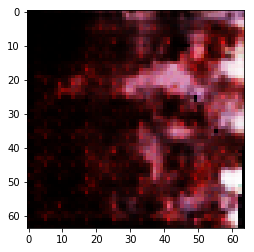

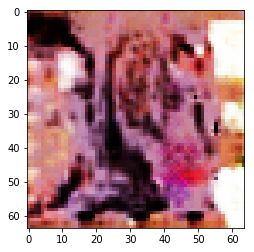

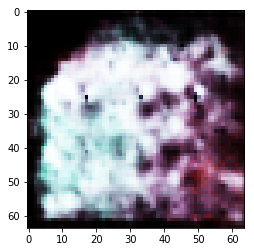

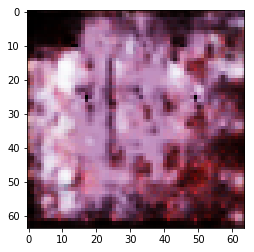

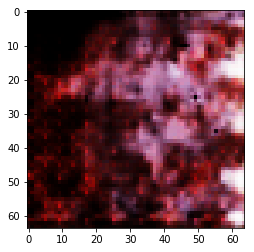

[152/500] Loss_d: 0.4745 Loss_g: 1.7090
[153/500] Loss_d: 0.0993 Loss_g: 2.9328
[154/500] Loss_d: 0.1034 Loss_g: 2.6836
[155/500] Loss_d: 0.3652 Loss_g: 4.5600
[156/500] Loss_d: 0.1600 Loss_g: 3.5011
[157/500] Loss_d: 1.0862 Loss_g: 2.2842
[158/500] Loss_d: 0.2813 Loss_g: 2.0698
[159/500] Loss_d: 0.0103 Loss_g: 2.9693
[160/500] Loss_d: 0.0869 Loss_g: 2.9361
[161/500] Loss_d: 0.1645 Loss_g: 2.5195
[162/500] Loss_d: 0.5579 Loss_g: 1.8526
[163/500] Loss_d: 0.4525 Loss_g: 1.8398
[164/500] Loss_d: 0.0817 Loss_g: 3.3685
[165/500] Loss_d: 0.4131 Loss_g: 1.8697
[166/500] Loss_d: 0.1666 Loss_g: 2.2156
[167/500] Loss_d: 0.6468 Loss_g: 2.1191
[168/500] Loss_d: 0.8350 Loss_g: 1.2353
[169/500] Loss_d: 0.0268 Loss_g: 2.8119
[170/500] Loss_d: 0.3634 Loss_g: 1.5915
[171/500] Loss_d: 0.2693 Loss_g: 2.3166
[172/500] Loss_d: 0.8466 Loss_g: 0.8248
[173/500] Loss_d: 0.3197 Loss_g: 2.4915
[174/500] Loss_d: 0.0608 Loss_g: 2.6746
[175/500] Loss_d: 0.7436 Loss_g: 1.1201
[176/500] Loss_d: 0.4566 Loss_g: 1.8053


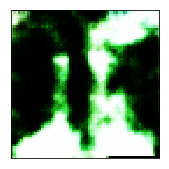

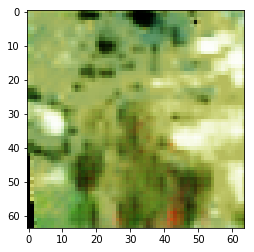

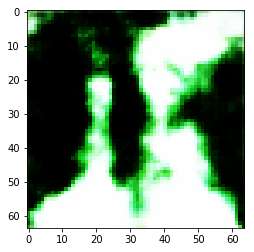

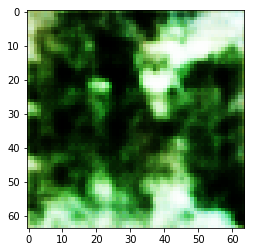

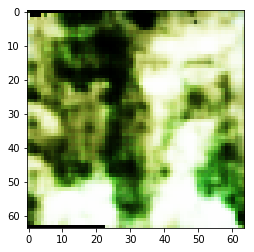

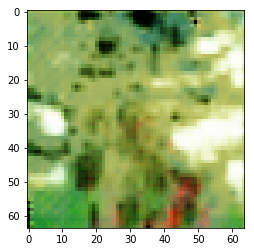

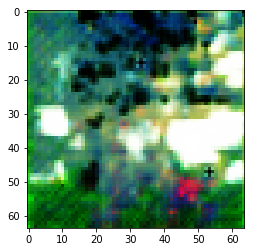

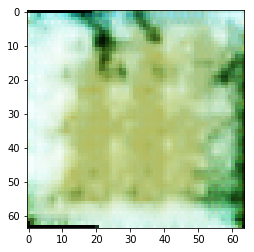

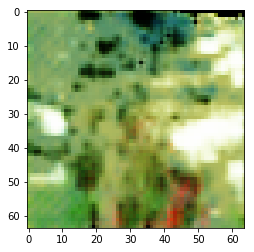

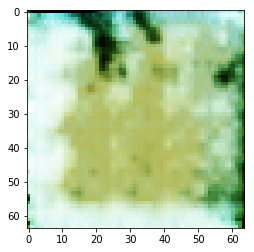

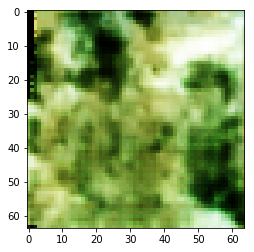

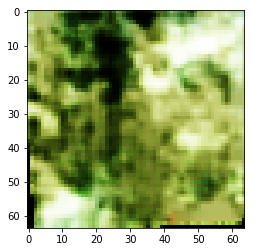

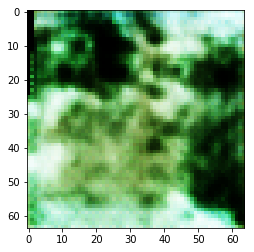

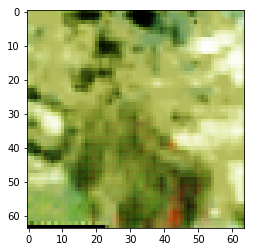

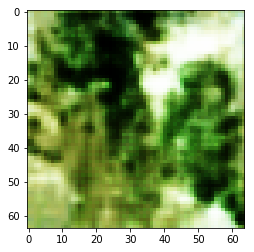

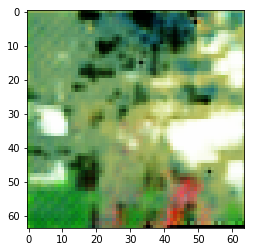

[182/500] Loss_d: 0.0275 Loss_g: 2.9089
[183/500] Loss_d: 0.4047 Loss_g: 1.7095
[184/500] Loss_d: 0.2501 Loss_g: 2.2891
[185/500] Loss_d: 0.2917 Loss_g: 1.7644
[186/500] Loss_d: 0.5748 Loss_g: 1.7782
[187/500] Loss_d: 0.3193 Loss_g: 2.1800
[188/500] Loss_d: 0.1039 Loss_g: 2.7611
[189/500] Loss_d: 0.3617 Loss_g: 2.2156
[190/500] Loss_d: 0.5507 Loss_g: 2.9933
[191/500] Loss_d: 0.9793 Loss_g: 1.1365
[192/500] Loss_d: 0.4902 Loss_g: 1.7537
[193/500] Loss_d: 0.0644 Loss_g: 2.7293
[194/500] Loss_d: 0.2471 Loss_g: 2.2022
[195/500] Loss_d: 0.0488 Loss_g: 2.6621
[196/500] Loss_d: 1.2324 Loss_g: 0.8002
[197/500] Loss_d: 0.0081 Loss_g: 3.5227
[198/500] Loss_d: 0.2250 Loss_g: 2.1103
[199/500] Loss_d: 0.1617 Loss_g: 2.3947
[200/500] Loss_d: 0.1924 Loss_g: 2.3968
[201/500] Loss_d: 0.4548 Loss_g: 1.6181
[202/500] Loss_d: 0.2714 Loss_g: 2.1826
[203/500] Loss_d: 0.0038 Loss_g: 3.1819
[204/500] Loss_d: 0.2289 Loss_g: 2.5852
[205/500] Loss_d: 0.0336 Loss_g: 2.8350
[206/500] Loss_d: 0.0238 Loss_g: 3.1763


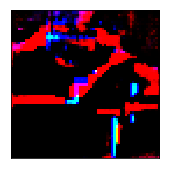

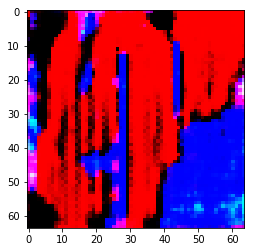

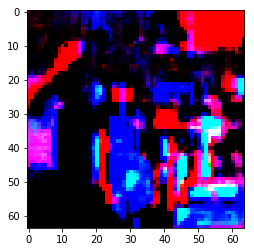

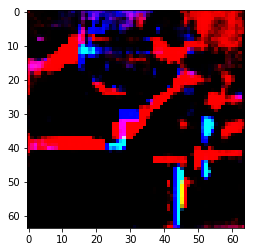

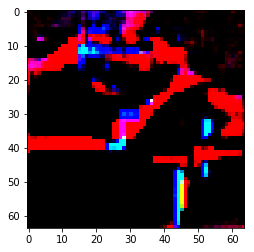

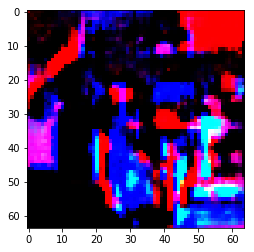

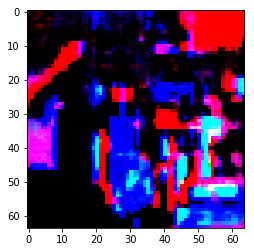

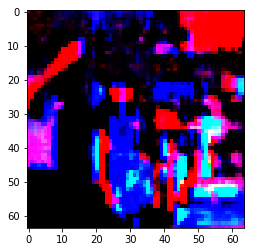

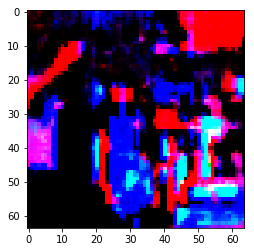

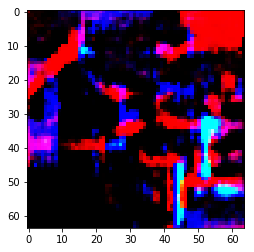

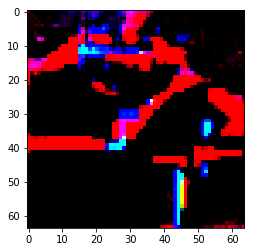

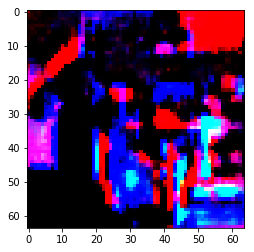

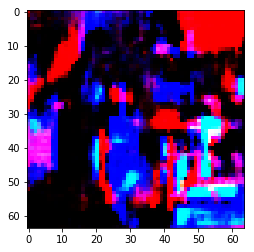

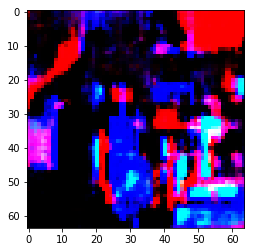

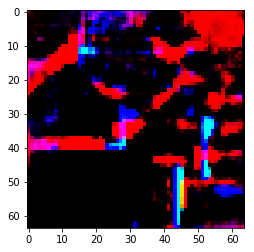

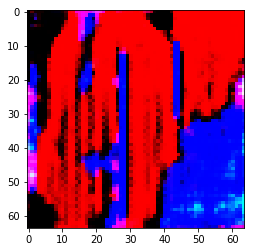

[212/500] Loss_d: 0.0212 Loss_g: 2.9952
[213/500] Loss_d: 0.1127 Loss_g: 2.6760
[214/500] Loss_d: 0.2070 Loss_g: 2.1028
[215/500] Loss_d: 0.2274 Loss_g: 1.9847
[216/500] Loss_d: 0.6937 Loss_g: 1.1755
[217/500] Loss_d: 0.5783 Loss_g: 2.0713
[218/500] Loss_d: 0.3677 Loss_g: 1.8085
[219/500] Loss_d: 0.3181 Loss_g: 1.9022
[220/500] Loss_d: 0.0951 Loss_g: 3.4955
[221/500] Loss_d: 0.0378 Loss_g: 2.9569
[222/500] Loss_d: 0.5597 Loss_g: 1.1638
[223/500] Loss_d: 0.4616 Loss_g: 1.7891
[224/500] Loss_d: 0.1959 Loss_g: 2.2336
[225/500] Loss_d: 0.1128 Loss_g: 2.3961
[226/500] Loss_d: 0.1288 Loss_g: 2.6985
[227/500] Loss_d: 0.8232 Loss_g: 1.5213
[228/500] Loss_d: 0.4536 Loss_g: 2.0589
[229/500] Loss_d: 0.0336 Loss_g: 2.8256
[230/500] Loss_d: 1.0532 Loss_g: 1.3258
[231/500] Loss_d: 0.2462 Loss_g: 2.4014
[232/500] Loss_d: 1.2103 Loss_g: 0.6206
[233/500] Loss_d: 0.3384 Loss_g: 1.8400
[234/500] Loss_d: 0.3930 Loss_g: 1.7091
[235/500] Loss_d: 0.1071 Loss_g: 2.4818
[236/500] Loss_d: 0.1784 Loss_g: 2.2849


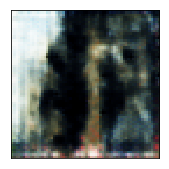

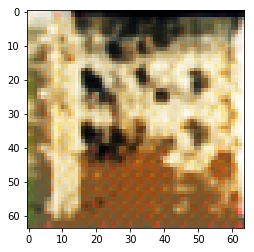

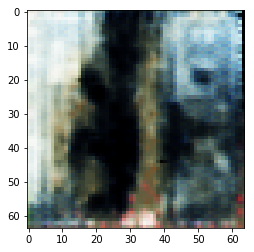

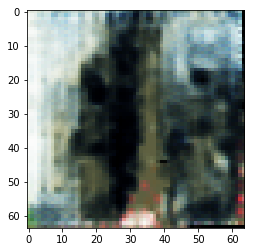

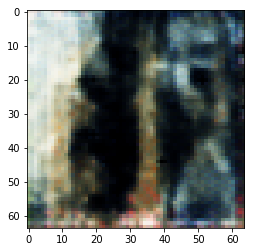

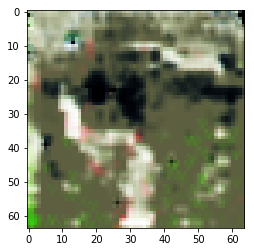

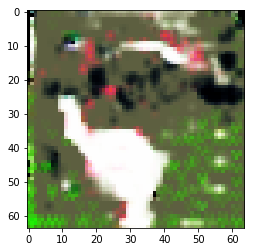

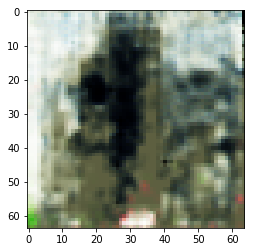

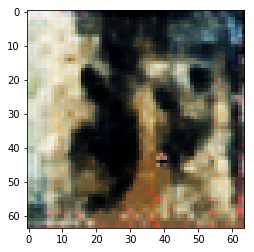

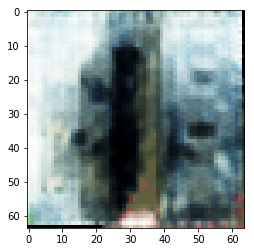

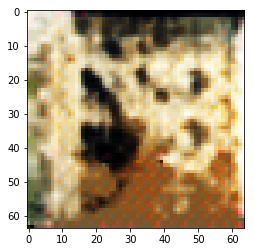

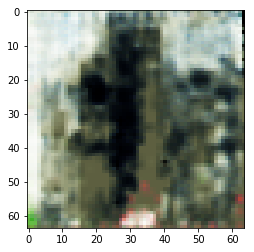

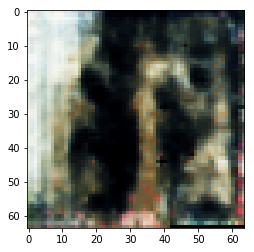

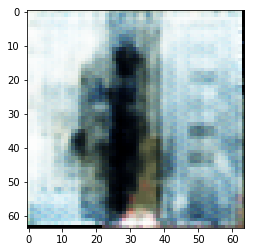

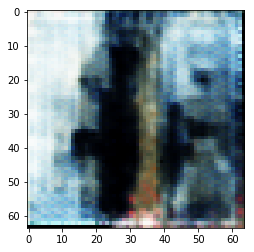

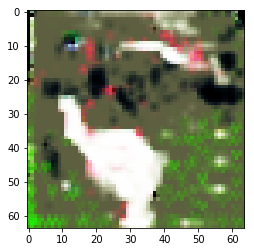

[242/500] Loss_d: 0.1965 Loss_g: 2.1687
[243/500] Loss_d: 0.5167 Loss_g: 1.2950
[244/500] Loss_d: 0.1040 Loss_g: 2.3478
[245/500] Loss_d: 0.1899 Loss_g: 2.2601
[246/500] Loss_d: 0.6127 Loss_g: 1.3352
[247/500] Loss_d: 0.2628 Loss_g: 2.1952
[248/500] Loss_d: 0.0731 Loss_g: 2.4838
[249/500] Loss_d: 0.1810 Loss_g: 2.2710
[250/500] Loss_d: 0.0717 Loss_g: 2.7065
[251/500] Loss_d: 0.2839 Loss_g: 2.2244
[252/500] Loss_d: 0.2881 Loss_g: 1.9908
[253/500] Loss_d: 0.5293 Loss_g: 1.4443
[254/500] Loss_d: 0.1677 Loss_g: 2.5560
[255/500] Loss_d: 0.2479 Loss_g: 2.2366
[256/500] Loss_d: 0.1160 Loss_g: 2.4173
[257/500] Loss_d: 0.0979 Loss_g: 2.5997
[258/500] Loss_d: 0.1128 Loss_g: 2.6048
[259/500] Loss_d: 0.1984 Loss_g: 2.4349
[260/500] Loss_d: 0.3325 Loss_g: 2.0610
[261/500] Loss_d: 0.5479 Loss_g: 1.3972
[262/500] Loss_d: 0.0430 Loss_g: 2.9406
[263/500] Loss_d: 0.4710 Loss_g: 1.4967
[264/500] Loss_d: 0.2260 Loss_g: 2.1619
[265/500] Loss_d: 0.8556 Loss_g: 1.6633
[266/500] Loss_d: 0.2084 Loss_g: 2.2290


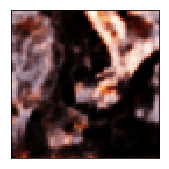

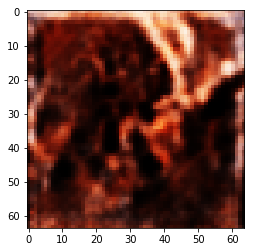

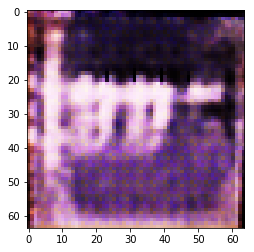

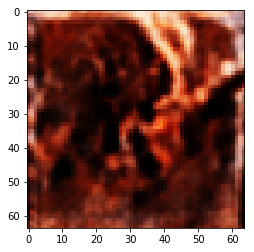

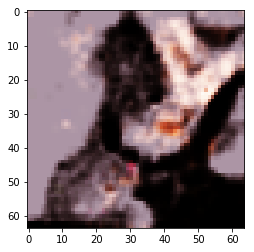

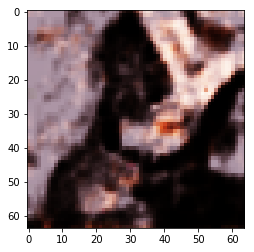

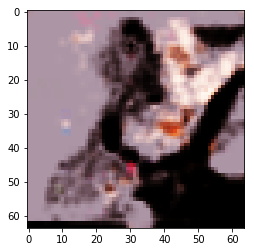

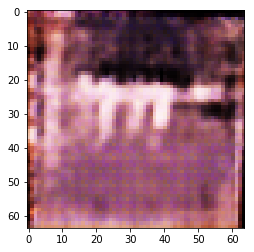

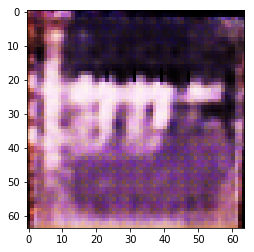

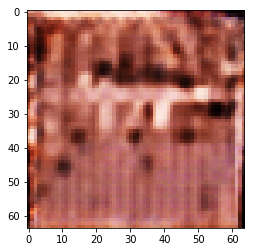

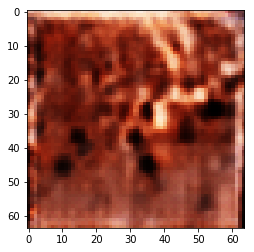

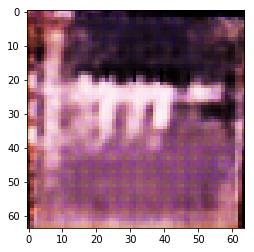

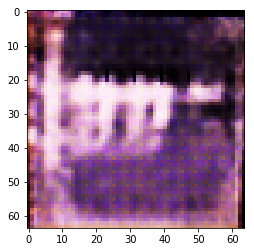

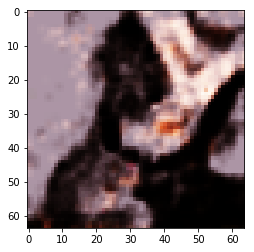

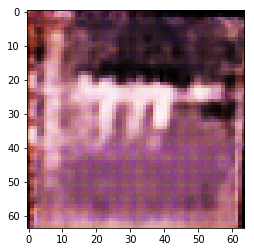

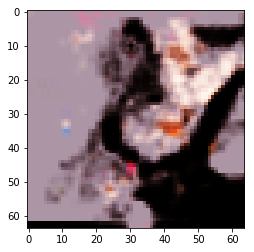

[272/500] Loss_d: 0.0186 Loss_g: 3.4006
[273/500] Loss_d: 0.3637 Loss_g: 1.7112
[274/500] Loss_d: 0.2573 Loss_g: 1.9496
[275/500] Loss_d: 0.6511 Loss_g: 1.2574
[276/500] Loss_d: 0.0343 Loss_g: 2.8133
[277/500] Loss_d: 0.7495 Loss_g: 1.2486
[278/500] Loss_d: 0.3025 Loss_g: 1.8556
[279/500] Loss_d: 0.2825 Loss_g: 2.0343
[280/500] Loss_d: 0.2993 Loss_g: 1.8862
[281/500] Loss_d: 0.1491 Loss_g: 2.3841
[282/500] Loss_d: 0.1090 Loss_g: 2.5444
[283/500] Loss_d: 0.3699 Loss_g: 1.6697
[284/500] Loss_d: 0.3119 Loss_g: 3.4296
[285/500] Loss_d: 0.4029 Loss_g: 1.7741
[286/500] Loss_d: 0.0169 Loss_g: 2.9992
[287/500] Loss_d: 0.5137 Loss_g: 1.5375
[288/500] Loss_d: 0.3285 Loss_g: 1.9096
[289/500] Loss_d: 0.9463 Loss_g: 1.3014
[290/500] Loss_d: 0.8156 Loss_g: 1.8324
[291/500] Loss_d: 0.6771 Loss_g: 1.2584
[292/500] Loss_d: 0.5086 Loss_g: 1.5467
[293/500] Loss_d: 0.3435 Loss_g: 1.6838
[294/500] Loss_d: 0.2221 Loss_g: 2.3517
[295/500] Loss_d: 0.4412 Loss_g: 1.5160
[296/500] Loss_d: 0.0055 Loss_g: 3.4704


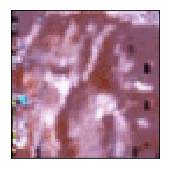

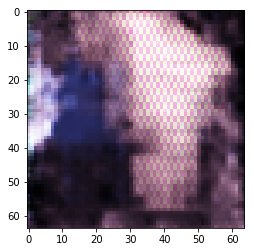

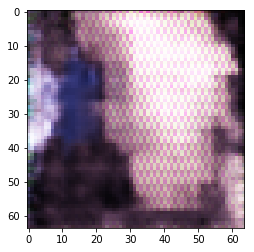

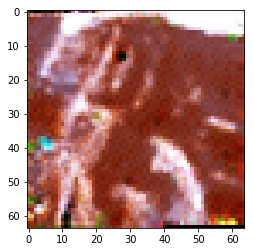

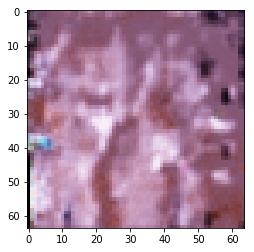

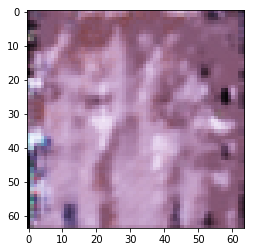

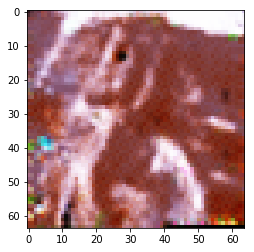

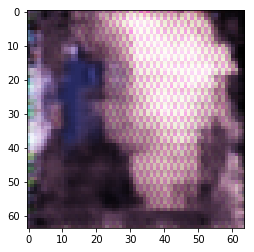

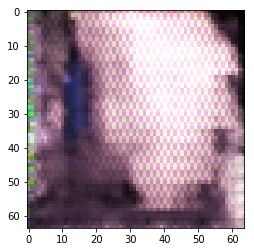

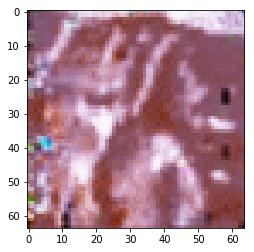

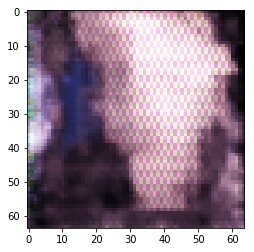

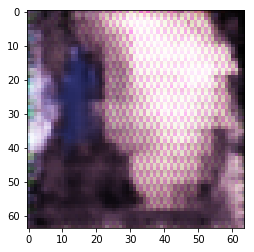

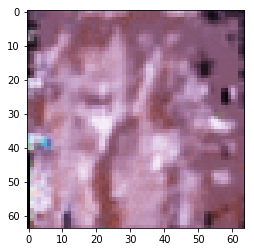

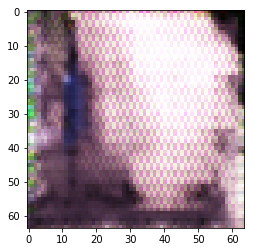

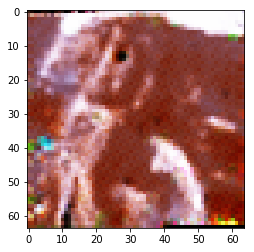

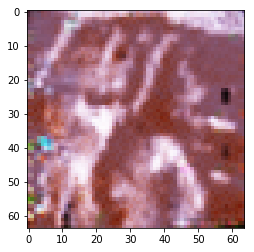

[302/500] Loss_d: 0.4080 Loss_g: 1.6139
[303/500] Loss_d: 0.0070 Loss_g: 3.2713
[304/500] Loss_d: 1.2221 Loss_g: 0.9621
[305/500] Loss_d: 0.5401 Loss_g: 1.6839
[306/500] Loss_d: 0.5121 Loss_g: 1.2374
[307/500] Loss_d: 0.2868 Loss_g: 1.9783
[308/500] Loss_d: 0.4044 Loss_g: 1.5484
[309/500] Loss_d: 0.1410 Loss_g: 2.2632
[310/500] Loss_d: 0.5042 Loss_g: 1.3634
[311/500] Loss_d: 0.8840 Loss_g: 1.2085
[312/500] Loss_d: 0.2640 Loss_g: 1.8997
[313/500] Loss_d: 0.3400 Loss_g: 1.5291
[314/500] Loss_d: 0.2858 Loss_g: 2.0321
[315/500] Loss_d: 0.6872 Loss_g: 1.2992
[316/500] Loss_d: 0.0196 Loss_g: 2.8944
[317/500] Loss_d: 0.1670 Loss_g: 2.2291
[318/500] Loss_d: 0.2551 Loss_g: 2.0222
[319/500] Loss_d: 0.3981 Loss_g: 1.7671
[320/500] Loss_d: 0.1810 Loss_g: 2.0449
[321/500] Loss_d: 0.0046 Loss_g: 3.1980
[322/500] Loss_d: 0.1775 Loss_g: 2.1165
[323/500] Loss_d: 0.1713 Loss_g: 2.1860
[324/500] Loss_d: 0.1647 Loss_g: 2.0935
[325/500] Loss_d: 0.0840 Loss_g: 2.4240
[326/500] Loss_d: 0.7579 Loss_g: 1.2193


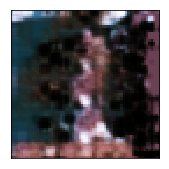

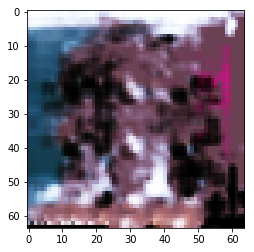

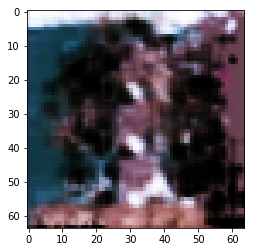

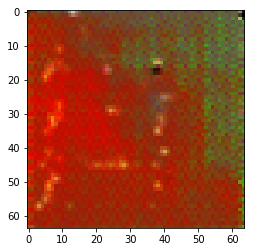

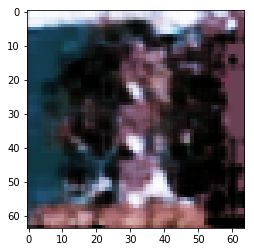

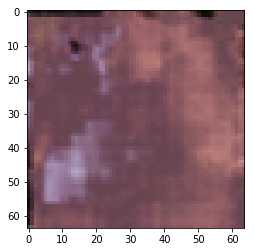

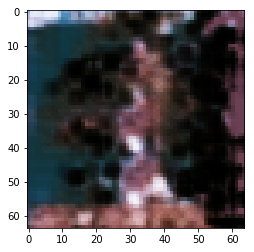

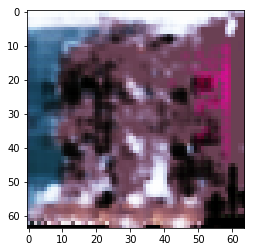

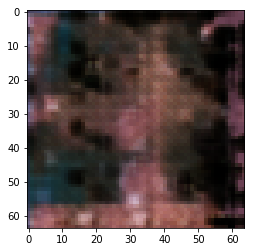

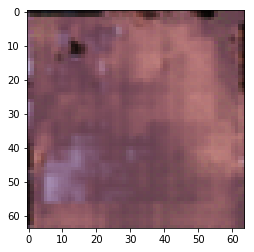

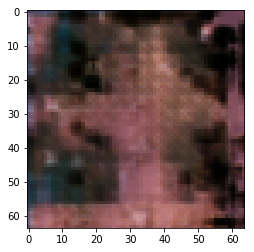

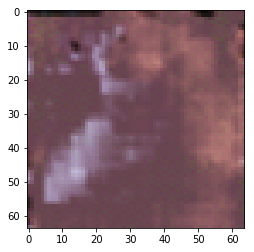

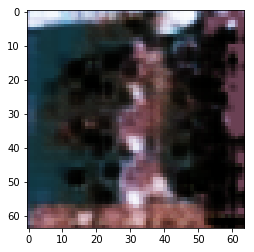

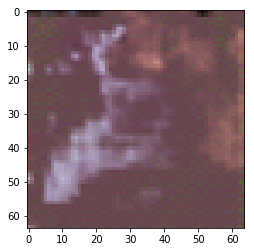

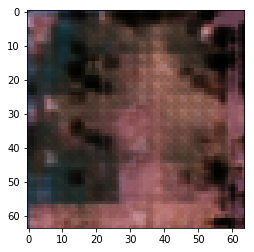

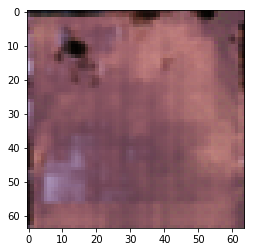

[332/500] Loss_d: 0.3431 Loss_g: 1.9893
[333/500] Loss_d: 0.1444 Loss_g: 2.2411
[334/500] Loss_d: 0.0402 Loss_g: 2.7778
[335/500] Loss_d: 0.6360 Loss_g: 1.3352
[336/500] Loss_d: 0.4784 Loss_g: 2.2692
[337/500] Loss_d: 1.0368 Loss_g: 0.8509
[338/500] Loss_d: 0.3335 Loss_g: 1.8256
[339/500] Loss_d: 0.2063 Loss_g: 2.1082
[340/500] Loss_d: 0.3911 Loss_g: 1.5711
[341/500] Loss_d: 0.7223 Loss_g: 1.0706
[342/500] Loss_d: 0.5027 Loss_g: 1.3843
[343/500] Loss_d: 0.4688 Loss_g: 1.5065
[344/500] Loss_d: 0.3465 Loss_g: 2.3799
[345/500] Loss_d: 0.8663 Loss_g: 1.1052
[346/500] Loss_d: 0.1745 Loss_g: 2.0948
[347/500] Loss_d: 0.1211 Loss_g: 2.3046
[348/500] Loss_d: 0.3573 Loss_g: 1.7237
[349/500] Loss_d: 0.3003 Loss_g: 2.3863
[350/500] Loss_d: 0.3233 Loss_g: 1.6985
[351/500] Loss_d: 0.2314 Loss_g: 2.0183
[352/500] Loss_d: 1.3351 Loss_g: 0.4734
[353/500] Loss_d: 0.4229 Loss_g: 1.5350
[354/500] Loss_d: 0.2493 Loss_g: 1.8283
[355/500] Loss_d: 0.5245 Loss_g: 1.5500
[356/500] Loss_d: 0.5949 Loss_g: 1.5700


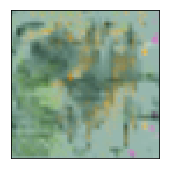

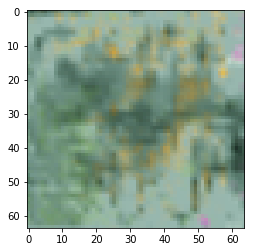

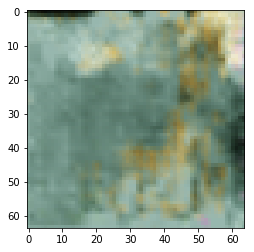

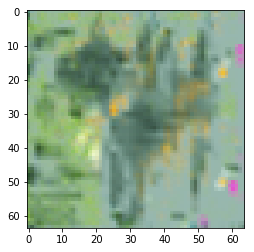

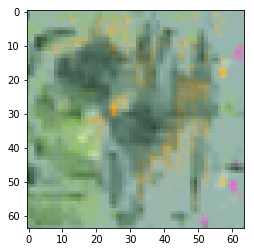

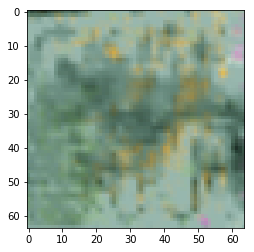

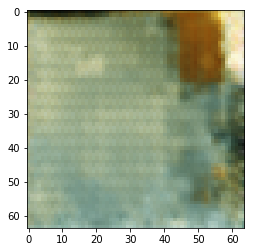

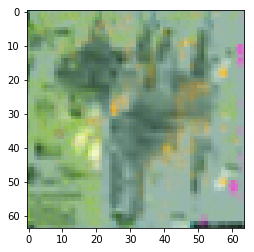

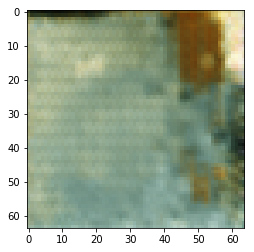

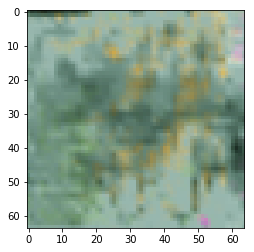

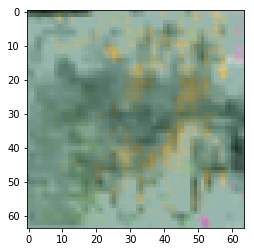

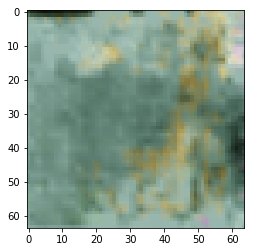

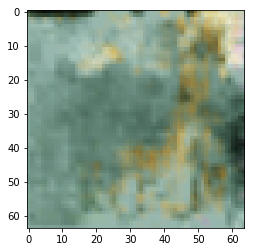

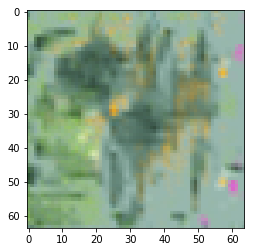

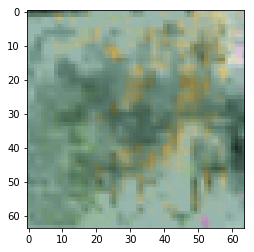

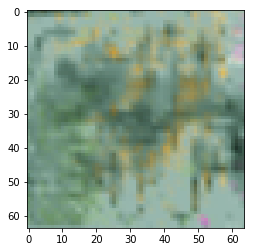

[362/500] Loss_d: 0.2984 Loss_g: 1.7741
[363/500] Loss_d: 0.9248 Loss_g: 0.8527
[364/500] Loss_d: 0.2797 Loss_g: 2.3475
[365/500] Loss_d: 0.2314 Loss_g: 2.0354
[366/500] Loss_d: 0.9762 Loss_g: 0.8628
[367/500] Loss_d: 0.2924 Loss_g: 1.9069
[368/500] Loss_d: 0.3330 Loss_g: 1.7146
[369/500] Loss_d: 0.3299 Loss_g: 1.6969
[370/500] Loss_d: 0.2663 Loss_g: 1.8036
[371/500] Loss_d: 0.1311 Loss_g: 2.4659
[372/500] Loss_d: 0.9913 Loss_g: 0.9580
[373/500] Loss_d: 0.2910 Loss_g: 1.7794
[374/500] Loss_d: 0.6765 Loss_g: 1.0788
[375/500] Loss_d: 0.0805 Loss_g: 2.4966
[376/500] Loss_d: 0.2029 Loss_g: 2.0145
[377/500] Loss_d: 0.2675 Loss_g: 2.0860
[378/500] Loss_d: 0.3927 Loss_g: 2.1891
[379/500] Loss_d: 0.8494 Loss_g: 1.0245
[380/500] Loss_d: 0.1415 Loss_g: 2.1776
[381/500] Loss_d: 1.1353 Loss_g: 1.1706
[382/500] Loss_d: 0.6263 Loss_g: 1.2604
[383/500] Loss_d: 0.8356 Loss_g: 1.5424
[384/500] Loss_d: 0.0846 Loss_g: 2.3808
[385/500] Loss_d: 0.5485 Loss_g: 1.3058
[386/500] Loss_d: 0.3528 Loss_g: 1.7239


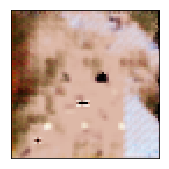

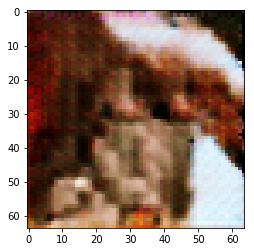

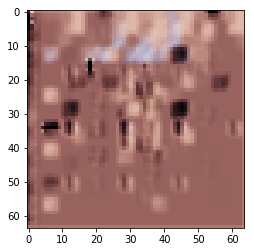

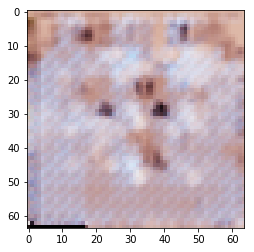

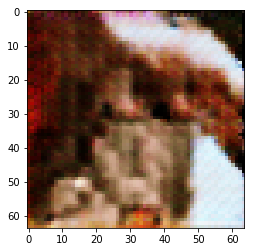

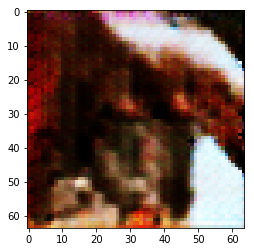

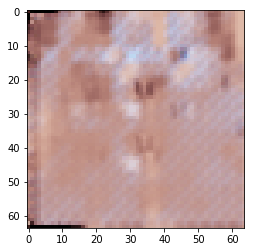

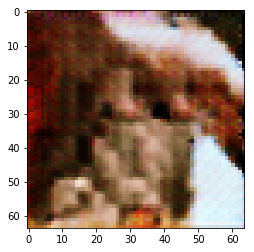

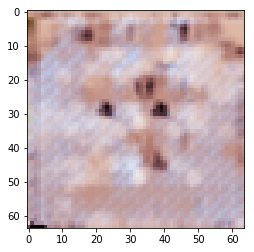

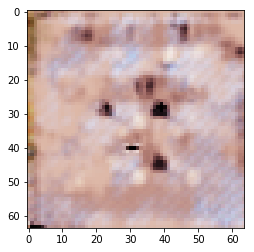

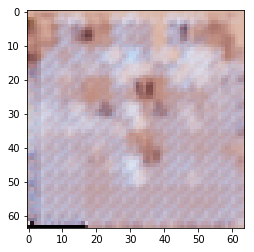

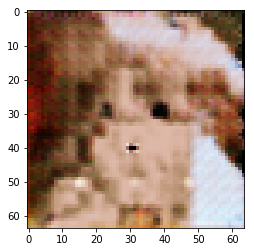

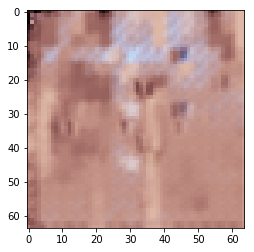

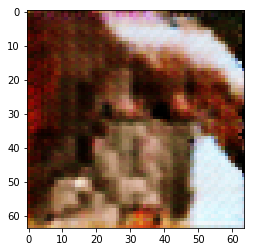

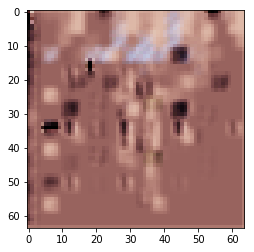

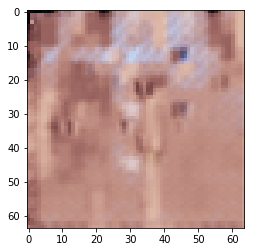

[392/500] Loss_d: 0.4643 Loss_g: 1.5488
[393/500] Loss_d: 0.0677 Loss_g: 2.5150
[394/500] Loss_d: 0.0685 Loss_g: 2.5459
[395/500] Loss_d: 0.2747 Loss_g: 1.7878
[396/500] Loss_d: 0.9306 Loss_g: 0.9044
[397/500] Loss_d: 1.2761 Loss_g: 0.5096
[398/500] Loss_d: 1.2506 Loss_g: 0.5016
[399/500] Loss_d: 0.2695 Loss_g: 1.8688
[400/500] Loss_d: 0.5006 Loss_g: 1.3314
[401/500] Loss_d: 0.1823 Loss_g: 2.1201
[402/500] Loss_d: 0.3528 Loss_g: 1.7209
[403/500] Loss_d: 0.1002 Loss_g: 2.3941
[404/500] Loss_d: 0.1691 Loss_g: 2.0506
[405/500] Loss_d: 0.1158 Loss_g: 2.2419
[406/500] Loss_d: 1.1479 Loss_g: 0.7598
[407/500] Loss_d: 0.6992 Loss_g: 1.2146
[408/500] Loss_d: 0.6250 Loss_g: 1.2893
[409/500] Loss_d: 0.0967 Loss_g: 3.9118
[410/500] Loss_d: 0.1416 Loss_g: 2.2026
[411/500] Loss_d: 0.4738 Loss_g: 1.3885
[412/500] Loss_d: 0.3543 Loss_g: 1.7264
[413/500] Loss_d: 0.4672 Loss_g: 1.3650
[414/500] Loss_d: 0.5576 Loss_g: 1.2332
[415/500] Loss_d: 0.1465 Loss_g: 2.1826
[416/500] Loss_d: 0.0918 Loss_g: 2.3692


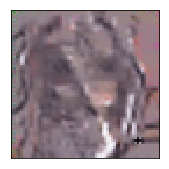

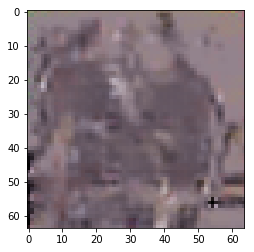

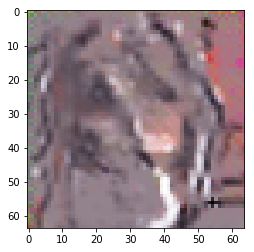

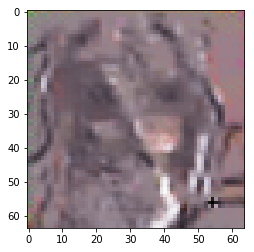

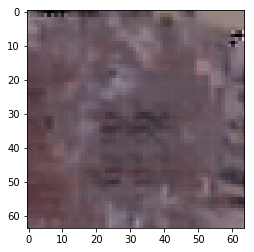

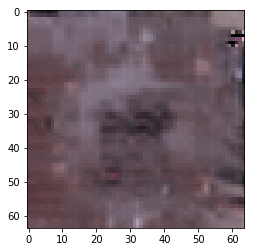

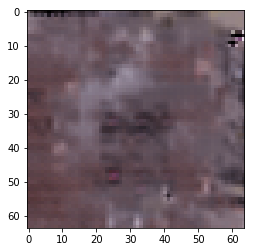

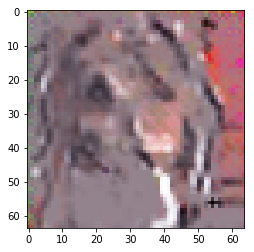

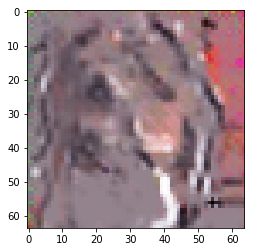

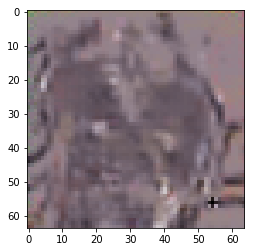

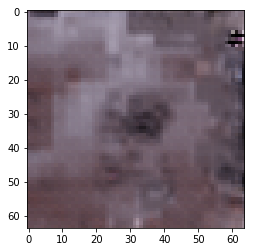

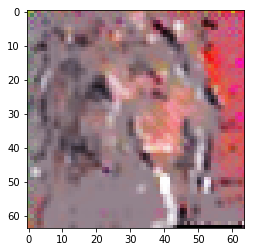

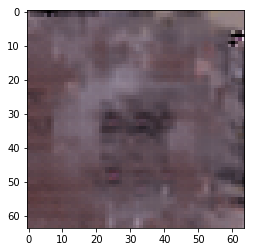

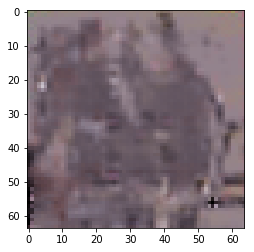

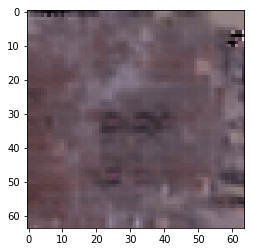

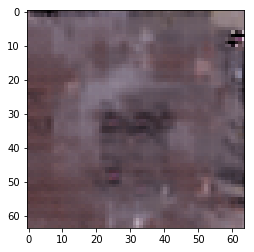

[422/500] Loss_d: 0.2003 Loss_g: 1.9102
[423/500] Loss_d: 0.0948 Loss_g: 2.2752
[424/500] Loss_d: 0.1010 Loss_g: 2.4193
[425/500] Loss_d: 0.6164 Loss_g: 1.2193
[426/500] Loss_d: 0.2836 Loss_g: 1.9634
[427/500] Loss_d: 0.2466 Loss_g: 1.8170
[428/500] Loss_d: 0.2276 Loss_g: 1.9696
[429/500] Loss_d: 0.0056 Loss_g: 3.0777
[430/500] Loss_d: 0.1592 Loss_g: 2.0784
[431/500] Loss_d: 0.2843 Loss_g: 1.7196
[432/500] Loss_d: 0.0635 Loss_g: 2.4692
[433/500] Loss_d: 0.4559 Loss_g: 1.4420
[434/500] Loss_d: 0.8952 Loss_g: 0.8272
[435/500] Loss_d: 0.1246 Loss_g: 2.5174
[436/500] Loss_d: 0.5387 Loss_g: 1.3914
[437/500] Loss_d: 1.1456 Loss_g: 0.5648
[438/500] Loss_d: 0.6334 Loss_g: 1.1875
[439/500] Loss_d: 1.3521 Loss_g: 1.0225
[440/500] Loss_d: 0.3026 Loss_g: 1.7171
[441/500] Loss_d: 0.5363 Loss_g: 1.2973
[442/500] Loss_d: 0.7815 Loss_g: 0.8764
[443/500] Loss_d: 0.9976 Loss_g: 1.6066
[444/500] Loss_d: 0.6560 Loss_g: 1.1540
[445/500] Loss_d: 1.1798 Loss_g: 0.5795
[446/500] Loss_d: 0.3336 Loss_g: 1.6896


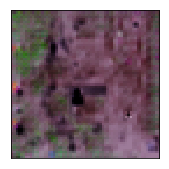

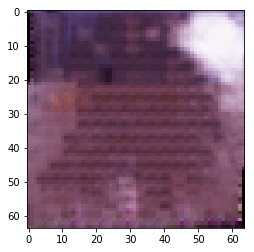

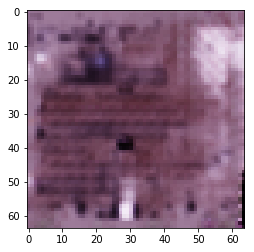

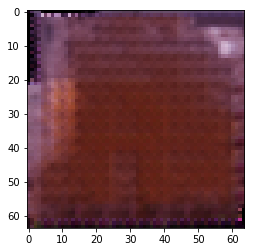

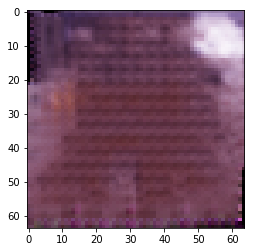

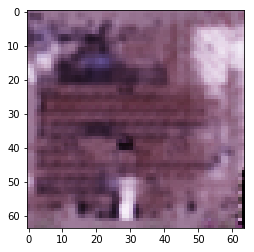

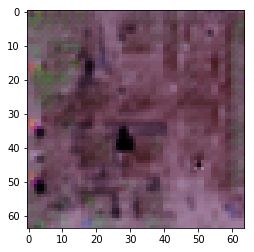

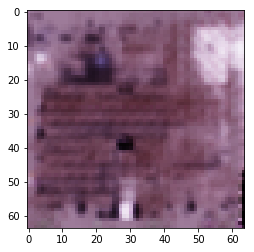

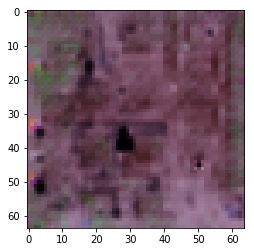

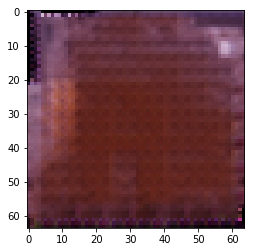

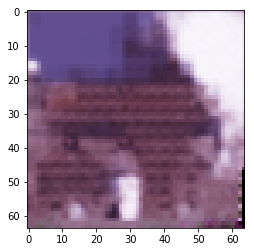

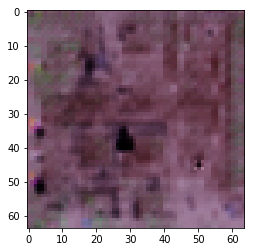

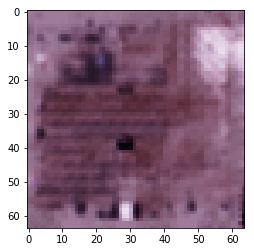

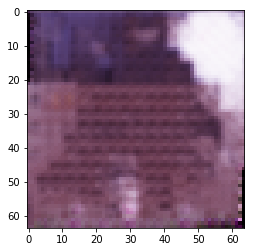

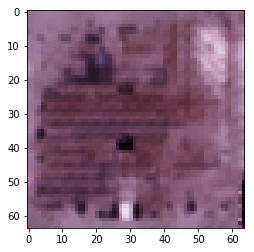

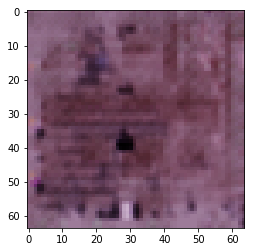

[452/500] Loss_d: 0.9718 Loss_g: 0.7768
[453/500] Loss_d: 0.3635 Loss_g: 1.5227
[454/500] Loss_d: 0.5578 Loss_g: 1.2800
[455/500] Loss_d: 0.1054 Loss_g: 2.4174
[456/500] Loss_d: 1.1472 Loss_g: 0.7230
[457/500] Loss_d: 0.7996 Loss_g: 1.0671
[458/500] Loss_d: 0.2339 Loss_g: 1.9239
[459/500] Loss_d: 1.2466 Loss_g: 0.5981
[460/500] Loss_d: 0.1184 Loss_g: 2.3345
[461/500] Loss_d: 0.4560 Loss_g: 1.4004
[462/500] Loss_d: 1.0711 Loss_g: 0.6931
[463/500] Loss_d: 0.7190 Loss_g: 0.9481
[464/500] Loss_d: 0.8411 Loss_g: 0.9599
[465/500] Loss_d: 1.5226 Loss_g: 0.4923
[466/500] Loss_d: 1.0156 Loss_g: 0.7854
[467/500] Loss_d: 0.6421 Loss_g: 1.1984
[468/500] Loss_d: 1.3884 Loss_g: 0.4351
[469/500] Loss_d: 0.5535 Loss_g: 1.2782
[470/500] Loss_d: 0.2148 Loss_g: 2.1337
[471/500] Loss_d: 0.8181 Loss_g: 0.9926
[472/500] Loss_d: 0.8986 Loss_g: 0.8860
[473/500] Loss_d: 0.9780 Loss_g: 0.9071
[474/500] Loss_d: 0.3644 Loss_g: 1.5962
[475/500] Loss_d: 0.2464 Loss_g: 1.7858
[476/500] Loss_d: 0.0514 Loss_g: 2.8099


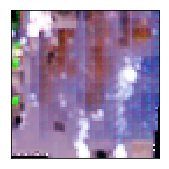

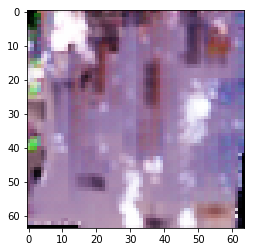

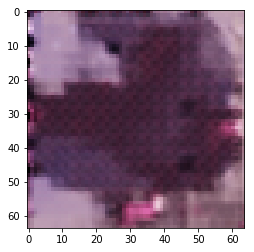

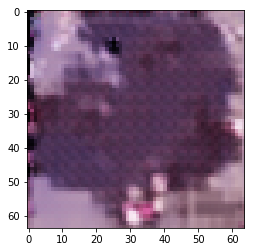

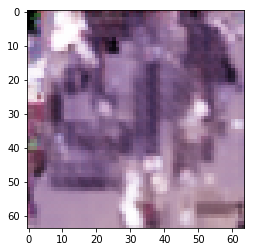

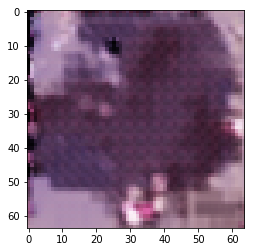

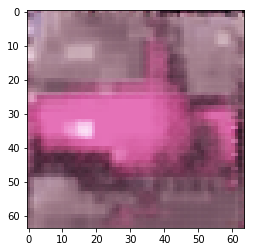

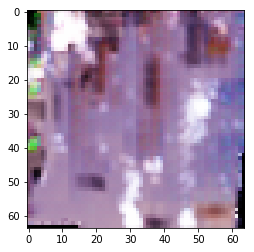

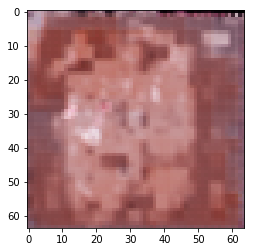

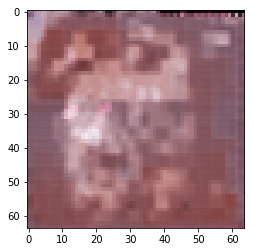

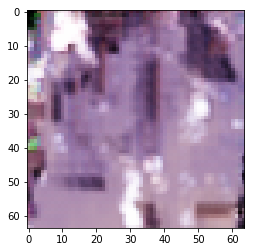

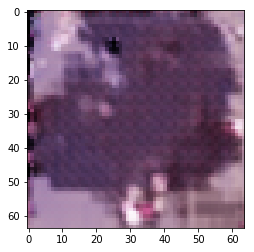

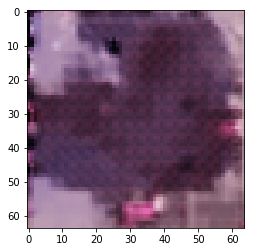

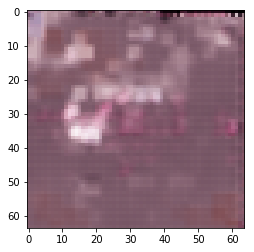

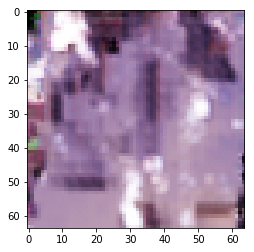

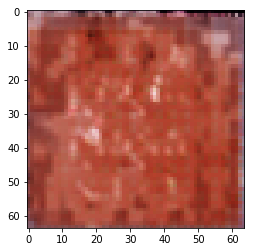

[482/500] Loss_d: 0.2183 Loss_g: 1.9304
[483/500] Loss_d: 0.7583 Loss_g: 1.0055
[484/500] Loss_d: 0.3885 Loss_g: 1.5489
[485/500] Loss_d: 1.0226 Loss_g: 0.7076
[486/500] Loss_d: 0.9942 Loss_g: 0.8719
[487/500] Loss_d: 1.4623 Loss_g: 0.5355
[488/500] Loss_d: 0.5304 Loss_g: 1.3564
[489/500] Loss_d: 0.4904 Loss_g: 1.3968
[490/500] Loss_d: 0.2189 Loss_g: 1.8803
[491/500] Loss_d: 0.5984 Loss_g: 1.1869
[492/500] Loss_d: 0.3827 Loss_g: 1.6307
[493/500] Loss_d: 1.4155 Loss_g: 0.4997
[494/500] Loss_d: 1.0219 Loss_g: 0.7086
[495/500] Loss_d: 0.6878 Loss_g: 1.1036
[496/500] Loss_d: 0.3674 Loss_g: 1.5834
[497/500] Loss_d: 0.6628 Loss_g: 1.0384
[498/500] Loss_d: 0.3409 Loss_g: 1.5622
[499/500] Loss_d: 0.3544 Loss_g: 1.6005
[500/500] Loss_d: 0.3129 Loss_g: 1.6771


In [9]:
for epoch in range(epochs):
    for i, real_images in enumerate(train_loader):
        # --------------------------------------
        # Update Discriminator network: maximize log(D(x)) + log(1 - D(G(z)))
        # --------------------------------------
        net_d.zero_grad()
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size, 1), real_label, device=device)
        
        scheduler_d.batch_step()
        output_real = net_d(real_images)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = net_g(noise)
        output_fake = net_d(fake.detach())
        err_d = (torch.mean((output_real - torch.mean(output_fake) - labels) ** 2) + 
                 torch.mean((output_fake - torch.mean(output_real) + labels) ** 2)) / 2
        err_d.backward(retain_graph=True)
        optimizer_d.step()
        
        # --------------------------------------
        # Update Generator network: maximize log(D(G(z)))
        # --------------------------------------
        net_g.zero_grad()
        scheduler_g.batch_step()
        output_fake = net_d(fake)   
        err_g = (torch.mean((output_real - torch.mean(output_fake) + labels) ** 2) +
                 torch.mean((output_fake - torch.mean(output_real) - labels) ** 2)) / 2
        err_g.backward()
        optimizer_g.step()
        
    print(f'[{epoch + 1}/{epochs}] Loss_d: {err_d.item():.4f} Loss_g: {err_g.item():.4f}')
    if epoch % 30 == 0:
        z = truncated_normal((35, nz, 1, 1), threshold=1)
        gen_z = torch.from_numpy(z).float().to(device)
        gen_images = (net_g(gen_z) + 1) / 2
        images = gen_images.to('cpu').clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        fig = plt.figure(figsize=(25, 16))
        for i, j in enumerate(images[:16]):
            ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
            plt.imshow(j)
            plt.show()
        

In [10]:
im_batch_size = 50
n_images = 10000

for i_batch in range(0, n_images, im_batch_size):
    z = truncated_normal((im_batch_size, nz, 1, 1), threshold=1)
    gen_z = torch.from_numpy(z).float().to(device)
    gen_images = (net_g(gen_z) + 1) / 2
    images = gen_images.to('cpu').clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], OUT_DIR / f'image_{i_batch + i_image:05d}.png')

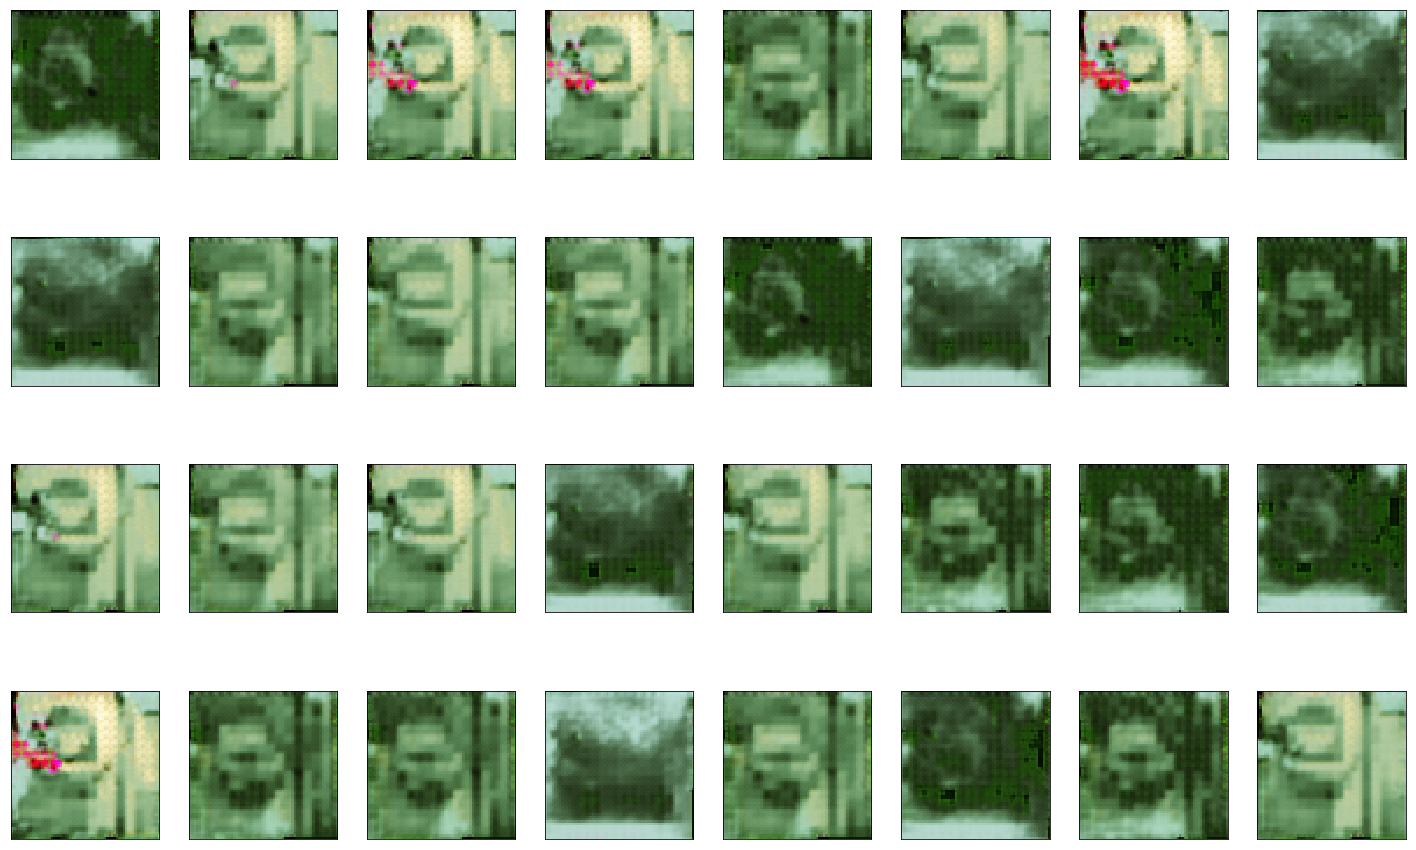

In [11]:
fig = plt.figure(figsize=(25, 16))
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [12]:
shutil.make_archive('images', 'zip', OUT_DIR)

'/kaggle/working/images.zip'

In [13]:
elapsed_time = time.time() - start_time
print(f'All process done in {int(elapsed_time // 3600)} hours {int(elapsed_time % 3600 // 60)} min.')

All process done in 4 hours 25 min.
